In [1]:
import pandas as pd
import numpy as np
import glob
from multiprocessing import Pool
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import seaborn as sns
from IPython.display import Image

In [2]:
def get_confusion_matrix(Y, Y_hat, label_mapping=None):
    if label_mapping is not None:
        report = classification_report(
            y_true=Y,
#             y_true=Y.argmax(axis=1),
            y_pred=Y_hat.argmax(axis=1),
            labels=list(label_mapping.keys()),
            target_names=list(label_mapping.values())
        )
    else:
        report = classification_report(
            y_true=Y,
#             y_true=Y.argmax(axis=1),
            y_pred=Y_hat.argmax(axis=1),
        )
    return report

In [3]:
def get_class_weights(y_train):
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train.flatten()),
                                                     y_train.flatten())
    class_weights = dict(zip(np.unique(y_train.flatten()), class_weights))
    return class_weights

In [4]:
def read_csv(file_path):
        csv_data_ = pd.read_csv(file_path, compression="gzip", header=None)
        return csv_data_
def get_activity_data(path_glob, n_files=5):
    file_list = glob.glob(path_glob)

    p = Pool()
    df_list = p.map(read_csv, file_list[:n_files])
    p.close()
    
    return pd.concat(df_list)

In [5]:
%%time
raw_data_ = get_activity_data("../../wpiukb/RawData/activity/part-*.gz", n_files=5)

CPU times: user 4.5 s, sys: 8.73 s, total: 13.2 s
Wall time: 15min 10s


In [6]:
filtered_raw_data_ = raw_data_[(raw_data_.apply(lambda x: sum(x == -99), axis=1) == 0)]

In [7]:
filtered_raw_data_.shape

(2736, 120961)

In [8]:
%%time
pheno_data_ = pd.read_csv("../../wpiukb/RawData/pheno/activitypheno.csv")
min(pheno_data_.userId), max(pheno_data_.userId)

CPU times: user 1.75 s, sys: 131 ms, total: 1.89 s
Wall time: 2.02 s


In [9]:
considered_pheno = ['userId', '1200', 'age']
filtered_pheno_data_ = pheno_data_[pheno_data_[considered_pheno].apply(
    lambda x: not(sum(x.isnull())>0), axis=1)
           ][considered_pheno]

In [14]:
Counter(filtered_pheno_data_['1200'])

Counter({1.0: 24533, 2.0: 45692, 3.0: 25788})

In [15]:
mapping_1200 = {
    0  : "Never",
    1  : "Sometimes",
    2  : "Usually",
}

In [16]:
all_data_ = pd.merge(filtered_raw_data_, filtered_pheno_data_, how='inner', right_on='userId', left_on=0)

In [17]:
all_data_.shape

(2734, 120964)

In [18]:
total_steps = int(7 * 24 * 60 * (60 / 5))
total_steps

120960

In [19]:
X_data = all_data_.iloc[:,1:total_steps+1].values
Y_data = all_data_.iloc[:,-2:].values

In [20]:
X_data.shape, Y_data.shape

((2734, 120960), (2734, 2))

In [21]:
X_reshaped = np.reshape(np.apply_along_axis(lambda x: np.split(x, 7), 1, X_data), (-1, total_steps//7))

In [22]:
Y_reshaped = np.repeat(Y_data, 7, axis=0)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_reshaped = scaler.fit_transform(X_reshaped)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


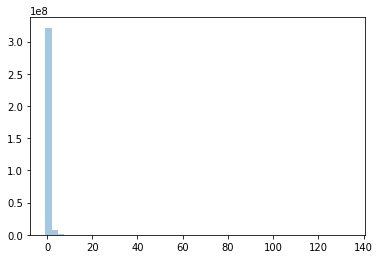

In [24]:
sns.distplot(X_reshaped.flatten(), kde=False)

In [ ]:
# def scale_X(X):
#     std_ = np.std(X_reshaped.flatten(order='K'))
#     mean_ = np.mean(X_reshaped.flatten(order='K'))
#     print(mean_, std_)
#     scaler = lambda x: (x-mean_)/std_
#     vfunc = np.vectorize(scaler)
#     return vfunc(X)

In [ ]:
# %%time
# X_reshaped = scale_X(X_reshaped)

In [ ]:
# %%time
# sns.distplot(X_reshaped.flatten(order='K'), kde=False)

In [32]:
X_reshaped = np.expand_dims(X_reshaped, -1)
Y_reshaped = np.expand_dims(Y_reshaped, -1)

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped.astype('float32'), 
                                                      Y_reshaped.astype('float32'),
                                                      test_size=0.2,
                                                      random_state=123)

In [82]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((15310, 17280, 1), (15310, 2, 1), (3828, 17280, 1), (3828, 2, 1))

In [83]:
Y_train[:1], Y_test[:1]

(array([[[ 2.],
         [64.]]], dtype=float32), array([[[ 3.],
         [65.]]], dtype=float32))

In [84]:
y_train_1200 = Y_train[:, 0] -1
y_test_1200  = Y_test[:, 0] -1
# y_train_1180 = Y_train[:, 1]
# y_test_1180  = Y_test[:, 1]
y_train_age  = Y_train[:, 1]
y_test_age   = Y_test[:, 1]

In [37]:
y_train_1200[:1], y_train_age[:1]

(array([[2.]], dtype=float32), array([[66.]], dtype=float32))

In [30]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import SeparableConv1D, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [31]:
X_train.shape[1:]

(17280,)

In [ ]:
# min(X_train.flatten()), max(X_train.flatten())

In [ ]:
# import seaborn as sns
# sns.distplot((X_train.flatten()), kde=False)

In [148]:
# CNN 1 branch
kernel_size = 12 * 15  #30 min convolution
max_pool_size = 3
dropout_rate = 0.3
num_classes = len(np.unique(y_train_1200))

input_sample_size = X_train.shape[1:]

model = Sequential()
model.add(Conv1D(64, kernel_size, padding='same', input_shape=input_sample_size))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling1D(pool_size= max_pool_size))
model.add(Dropout(dropout_rate))

model.add(Conv1D(32, kernel_size, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling1D(pool_size=max_pool_size))
model.add(Dropout(dropout_rate))

model.add(Flatten())
# model.add(Dense(32))
# model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.8))
# model.add(Dropout(dropout_rate))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# model.add(Dense(1))
# model.add(Activation('relu'))

In [149]:
X_train.shape

(15310, 17280, 1)

In [150]:
# kernel_size = 12 * 15  #120 min convolution
# max_pool_size = 3
# dropout_rate = 0.3
# num_classes = len(np.unique(y_train_1200))

# input_sample_size = X_train.shape[1:]
# inputs = Input(shape=input_sample_size, name='main_input')

# main_branch = Conv1D(64, kernel_size=kernel_size, padding="same")(inputs)
# main_branch = Activation("relu")(main_branch)
# main_branch = BatchNormalization(momentum=0.8)(main_branch)
# main_branch = MaxPooling1D(pool_size=max_pool_size)(main_branch)
# main_branch = Dropout(dropout_rate)(main_branch)

# main_branch = Conv1D(32, kernel_size=kernel_size, padding="same")(main_branch)
# main_branch = Activation("relu")(main_branch)
# main_branch = BatchNormalization(momentum=0.8)(main_branch)
# main_branch = MaxPooling1D(pool_size=max_pool_size)(main_branch)
# main_branch = Dropout(dropouta_rate)(main_branch)

# # # main_branch = Flatten()(main_branch)
# # main_branch = Dense(32)(main_branch)
# # main_branch = Activation('relu')(main_branch)
# # main_branch = Dropout(dropout_rate)(main_branch)


# age_branch = Flatten()(main_branch)
# age_branch = Dense(8)(age_branch)
# age_branch = Activation('relu')(age_branch)
# age_branch = Dropout(dropout_rate)(age_branch)
# age_branch = Dense(1, activation='relu', name='age_output')(age_branch)

# split_1200_branch = Flatten()(main_branch)
# split_1200_branch = Dense(8)(split_1200_branch)
# split_1200_branch = Activation('relu')(split_1200_branch)
# split_1200_branch = Dropout(dropout_rate)(split_1200_branch)
# split_1200_branch = Dense(num_classes, activation='softmax', name='split_1200_output')(split_1200_branch)

# model = Model(inputs = inputs,
#      outputs = [age_branch, split_1200_branch])

In [151]:
# # Dense NN
# dropout_rate = 0.5
# num_classes = len(np.unique(y_train_1200))

# input_sample_size = X_train.shape[1:]

# model = Sequential()
# model.add(Dense(128, input_shape=input_sample_size))
# model.add(Activation('relu'))
# model.add(BatchNormalization(momentum=0.8))
# model.add(Dropout(dropout_rate))

# model.add(Dense(64, input_shape=input_sample_size))
# model.add(Activation('relu'))
# model.add(BatchNormalization(momentum=0.8))
# model.add(Dropout(dropout_rate))

# model.add(Dense(32, input_shape=input_sample_size))
# model.add(Activation('relu'))
# model.add(BatchNormalization(momentum=0.8))
# model.add(Dropout(dropout_rate))

# model.add(Dense(1))
# model.add(Activation('relu'))

In [152]:
X_train.shape, y_train_age.shape, y_train_1200.shape

((15310, 17280, 1), (15310, 1), (15310, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 17280, 64)         11584     
_________________________________________________________________
activation_46 (Activation)   (None, 17280, 64)         0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 17280, 64)         256       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5760, 64)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 5760, 64)          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 5760, 32)          368672    
_________________________________________________________________
activation_47 (Activation)   (None, 5760, 32)          0         
__________

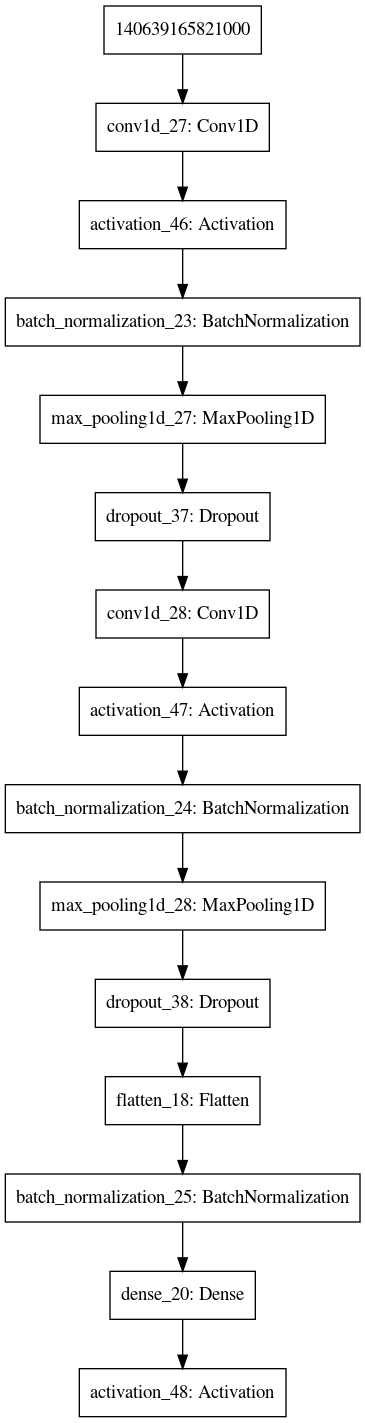

In [153]:
model.summary()
plot_model(model)
Image(retina=True, filename='model.png')

In [154]:
# %%time
# opt = keras.optimizers.rmsprop(lr=1e-3, decay=1e-6)

# model.compile(optimizer=opt,
#               loss={'age_output': 'mse', 'split_1200_output': 'sparse_categorical_crossentropy'},
#               loss_weights={'age_output': .1, 'split_1200_output': 1.})

# plot_progress = PlotProgress(entities=['loss'])

# try:
#     model.fit({'main_input': X_train},
#               {'age_output': y_train_age, 'split_1200_output': y_train_1200},
#               epochs=200, batch_size=128,
#               verbose=1,
#               callbacks=[plot_progress],
#               validation_split=0.2,
#              )
# except KeyboardInterrupt:
#     save_path = './keras-saves/mtl_latest.ckpt'
#     model.save(save_path)
#     print('\nOutput saved to: "{}"'.format(save_path))
#     pass

In [155]:
num_classes

3

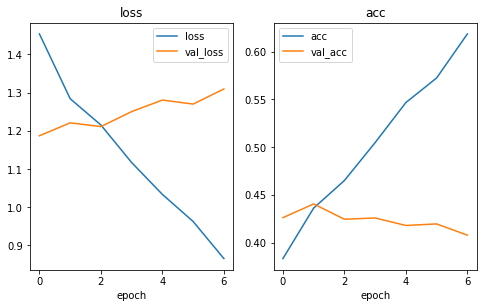

Epoch 8/150
 5504/12248 [============>.................] - ETA: 10s - loss: 0.7554 - acc: 0.6711CPU times: user 1min 19s, sys: 33.7 s, total: 1min 52s
Wall time: 2min 48s


In [156]:
%%time
batch_size = 128
epochs = 150

opt = keras.optimizers.Adam(lr=1e-4,decay=1e-6)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
# sparse_categorical_crossentropy

plot_progress = PlotProgress(entities=['loss', 'acc'])
# mean_absolute_error

save_path = './keras-saves/_latest.ckpt'
try:
    model.fit(X_train, y_train_1200,
              batch_size=batch_size,
              epochs=epochs,
#               class_weight=get_class_weights(y_train_1220),
#               class_weight={0.0: 0.5, 1.0: 2, 2.0: 4.0},
              validation_split=0.2,
              callbacks=[plot_progress],
              shuffle=True,
         )
except KeyboardInterrupt:
#     model.save(save_path)
#     print('\nOutput saved to: "{}./*"'.format(save_path))
    pass

In [91]:
np.mean(np.square(y_test_age - model.predict(X_test)))

4671.017

In [92]:
np.square?

In [ ]:
sns.distplot(y_train_age)

In [ ]:
17681/len(y_train_1200)

In [ ]:
sns.distplot(y_train_age.flatten())

In [ ]:
Counter(y_train_1200.flatten())

In [ ]:
model.predict(X_train)

In [85]:
print("Train Confusion Matrix\n", get_confusion_matrix(y_train_1200, model.predict(X_train), mapping_1200))
print("Test Confusion Matrix\n", get_confusion_matrix(y_test_1200, model.predict(X_test), mapping_1200))

Train Confusion Matrix
              precision    recall  f1-score   support

      Never       0.80      0.55      0.65      3843
  Sometimes       0.71      0.87      0.78      7360
    Usually       0.73      0.65      0.68      4107

avg / total       0.74      0.73      0.72     15310

Test Confusion Matrix
              precision    recall  f1-score   support

      Never       0.80      0.52      0.63       966
  Sometimes       0.72      0.87      0.79      1845
    Usually       0.71      0.66      0.68      1017

avg / total       0.74      0.73      0.72      3828



In [ ]:
Counter(np.argmax(model.predict(X_test), axis=1))

In [139]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entities=['loss']):
        self.entities = entities
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = {}
        self.val_losses = {}
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        
        for entity in self.entities:
            self.losses.update({
                '{}'.format(entity) : self.losses.get('{}'.format(entity), list()) + [logs.get('{}'.format(entity))]
            })
            self.val_losses.update({
                'val_{}'.format(entity) : self.val_losses.get('val_{}'.format(entity), list()) + [logs.get('val_{}'.format(entity))]
            })
        self.i += 1
        
        clear_output(wait=True)
        ncol = 2
        nrow = int(len(self.entities) / ncol) + 1
        plt.figure(figsize=(8, 10))
        
        for idx, entity in enumerate(self.entities):
            plt.subplot(nrow, ncol, idx + 1)
            plt.plot(self.x, self.losses.get("{}".format(entity)), label="{}".format(entity))
            plt.plot(self.x, self.val_losses.get("val_{}".format(entity)), label="val_{}".format(entity))
            plt.xlabel('epoch')
            plt.title(entity)
            plt.legend()
        plt.show();